In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fuzzywuzzy
!pip install surprise

     |████████████████████████████████| 11.8MB 12.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670926 sha256=38aee9d94ef5214c1bcf174ff12269d69784dc428910cbaf6d4566f4bc263ed2
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 데이터 불러오기

In [6]:
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/movies.csv', usecols=['movieId', 'title'])
df_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/ratings.csv', usecols=['userId', 'movieId', 'rating'])

num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
print('점수 안 매긴 갯수 :', rating_zero_cnt)

There are 610 unique users and 9724 unique movies in this data set
점수 안 매긴 갯수 : 5830804


# 데이터 자체가 Sparse함을 보임

In [8]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])

# 점수 안 매긴 것 0점으로 처리
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, 'number of ratings(Log)')

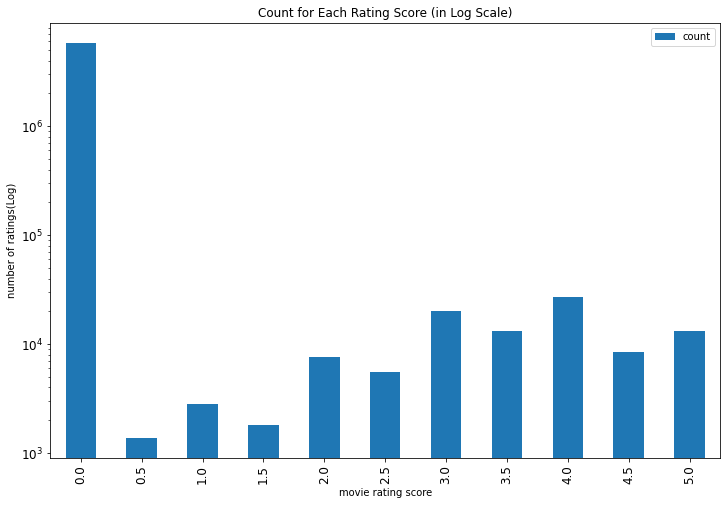

In [13]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings(Log)")

## 각 영화별 매겨진 리뷰의 갯수 (실질적으로 리뷰가 적은 영화가 꽤 많음 - 무의미한 데이터)


Text(0, 0.5, 'number of ratings (log scale)')

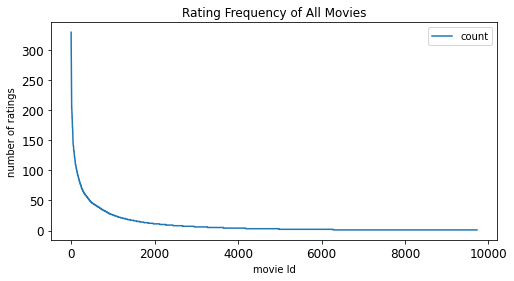

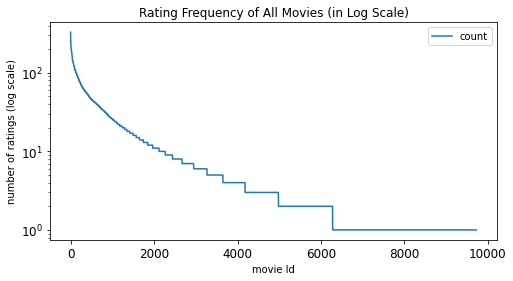

In [24]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True) \
    .plot(
        figsize=(8, 4),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

# log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(8, 4),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [26]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

# 상위 1%가 329개 평가를 받았고
# 상위 5%는 47개 평가
# 상위 20% 아래는 10개 이하의 평가를 기록

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [33]:
def drop_small_num_review_movies(rating_df, movie_count_df, threshold):
    popular_movies = list(set(movie_count_df.query('count >= @threshold').index))
    return rating_df[rating_df.movieId.isin(popular_movies)]

df_ratings_drop_movies = drop_small_num_review_movies(df_ratings, df_movies_cnt, 10)
print('기존 데이터: ', df_ratings.shape)
print('리뷰 수가 적은 영화를 제거한 데이터: ', df_ratings_drop_movies.shape)
df_ratings_drop_movies.head()

기존 데이터:  (100836, 3)
리뷰 수가 적은 영화를 제거한 데이터:  (81116, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 각 유저별 남긴 리뷰의 갯수(리뷰를 적게 남긴 유저가 많음 - 무의미한 추천이 될 확률이 높은 유저들)

In [34]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,211
2,26
3,24
4,179
5,44


Text(0, 0.5, 'number of ratings')

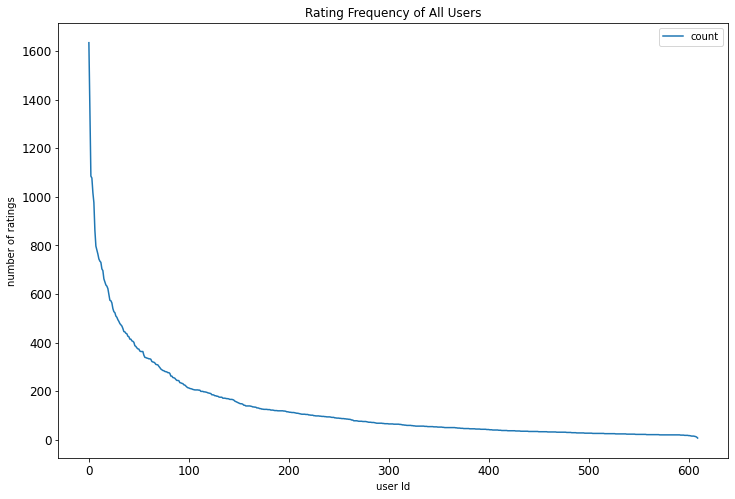

In [35]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [36]:
df_users_cnt['count'].quantile(np.arange(1, 0.2, -0.05))
# 상위 1%는 1634개 평가
# 상위 5%는 약 482개 평가

1.00    1634.00
0.95     482.95
0.90     333.00
0.85     234.65
0.80     190.20
0.75     148.00
0.70     122.00
0.65     105.00
0.60      92.00
0.55      75.00
0.50      64.50
0.45      56.00
0.40      50.00
0.35      43.00
0.30      36.70
0.25      33.00
Name: count, dtype: float64

In [ ]:
# filter data
# 50개이상
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of drop unpopular movies: ', df_ratings_drop_movies.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
df_ratings_drop_users.head()

shape of original ratings data:  (100836, 3)
shape of drop unpopular movies:  (81116, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (73868, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,1,4,6,7,10,11,15,16,17,18,19,20,21,22,23,24,27,28,29,32,33,34,36,38,39,40,41,42,43,45,47,50,51,52,57,58,59,62,63,64,...,559,560,561,562,563,564,566,567,570,571,572,573,577,579,580,582,583,584,585,586,587,588,590,591,592,593,594,596,597,599,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,4.0,...,5.0,3.0,4.0,4.5,0.0,0.0,0.0,3.5,4.0,0.0,4.0,5.0,0.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.0,0.0,4.0,0.0,2.5,0.0,4.0,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,3.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.5,0.0,4.5,...,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.5,0.0,3.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transforfm matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [ ]:
#n_jobs = cpu사용갯수, -1시 최대
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Guardians of the Galaxy (2014), with distance of 0.36458591835521437
2: Watchmen (2009), with distance of 0.364385175658941
3: Star Trek (2009), with distance of 0.36183954974701704
4: Inception (2010), with distance of 0.3600731056489729
5: Up (2009), with distance of 0.35088208398996457
6: Avatar (2009), with distance of 0.306339016530641
7: Iron Man 2 (2010), with distance of 0.30291483139956044
8: WALL·E (2008), with distance of 0.29827569654656105
9: Dark Knight, The (2008), with distance of 0.28361385176071996
10: Avengers, The (2012), with distance of 0.273085267898582


# Surprise 적용

In [ ]:
print('shape of original ratings data: ', df_ratings.shape)
print('shape of drop unpopular movies: ', df_ratings_drop_movies.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
df_ratings_drop_users.head()

shape of original ratings data:  (100836, 3)
shape of drop unpopular movies:  (81116, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (73868, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:


reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_ratings_drop_users[['userId', 'movieId', 'rating']], reader=reader)
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
algo = SVD()
algo.fit(train)

In [ ]:
prediction = algo.test(test)
print(prediction[:5])

[Prediction(uid=21, iid=135887, r_ui=4.5, est=3.0938873182255997, details={'was_impossible': False}), Prediction(uid=263, iid=720, r_ui=5.0, est=4.262884320389046, details={'was_impossible': False}), Prediction(uid=63, iid=1965, r_ui=4.5, est=3.208880645408104, details={'was_impossible': False}), Prediction(uid=391, iid=1228, r_ui=5.0, est=4.055846743795153, details={'was_impossible': False}), Prediction(uid=414, iid=71464, r_ui=4.5, est=3.7500519627469315, details={'was_impossible': False})]


In [ ]:
# user_id, movie_id, 예측평점 5쌍 출력 예시
result = [(pred.uid, pred.iid, pred.est) for pred in prediction[:5]]
print(result)

[(21, 135887, 3.0938873182255997), (263, 720, 4.262884320389046), (63, 1965, 3.208880645408104), (391, 1228, 4.055846743795153), (414, 71464, 3.7500519627469315)]


In [ ]:
# r_ui = None 의미는 100user 100movie에 실제 평점이 없다는 뜻
uid = str(100)
iid = str(100)
pred = algo.predict(uid, iid)
print(pred)

user: 100        item: 100        r_ui = None   est = 3.56   {'was_impossible': False}


In [ ]:
predictions = algo.test(test)
accuracy.rmse(predictions)

RMSE: 0.8525


0.8524663194078708

In [ ]:
results = cross_validate(SVD(), data, measures=['RMSE'], cv=5, verbose=False)
# print(results)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp

test_rmse    0.843666
fit_time     3.790418
test_time    0.157249
dtype: float64

In [ ]:
tmp = tmp.append(pd.Series('SVD', index=['Algorithm']))
tmp

test_rmse    0.843666
fit_time      3.79042
test_time    0.157249
Algorithm         SVD
dtype: object

In [ ]:
_l = []
_l.append(tmp)
pd.DataFrame(_l).set_index('Algorithm')

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.843666,3.790418,0.157249


In [ ]:
algo_rmse_list = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    print(str(algorithm).split(' ')[0].split('.')[-1])
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    algo_rmse_list.append(temp)

SVD
SVDpp
SlopeOne
NMF
NormalPredictor
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans
Computing the msd similarity matrix...
Don

In [ ]:
pd.DataFrame(algo_rmse_list).set_index('Algorithm').sort_values('test_rmse') 

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.828668,256.767355,5.753274
KNNBaseline,0.835020,0.232864,1.693794
SVD,0.844339,3.832743,0.112923
BaselineOnly,0.844593,0.161488,0.105606
KNNWithMeans,0.846294,0.093609,1.351240
KNNWithZScore,0.846399,0.127351,1.490014
SlopeOne,0.847528,1.219379,4.396501
NMF,0.870030,3.939561,0.114830
CoClustering,0.894346,1.313046,0.116397
